In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import random
import time

random_seed = 35
n = 100
sigmas = [0.01, 0.1, 0.2]
K = 10000 #number of iterations, if you want faster compilation reduce to 1000

random.seed(random_seed)
np.random.seed(random_seed)

In [2]:
def generate_synthetic_data(n, sigma):
    C = 0.01 * np.random.randn(n, n) + np.eye(n)
    D = np.diag(np.random.uniform(0, 1, n))
    A = np.dot(C, np.dot(D, C.T)) + sigma * np.eye(n)  # A = CDC^T + sigma*I
    b = np.random.uniform(0, 1, n)
    return A, b

def least_squares_function(x, A, b):
    return 0.5 * np.linalg.norm(np.dot(A, x) - b)**2

datasets = []
for sigma in sigmas:
    A, b = generate_synthetic_data(n, sigma)
    datasets.append((A, b, sigma))

A, b, sigma = datasets[1]

ATA = np.dot(A.T, A)
L = np.linalg.eigvalsh(ATA).max()
mu = np.linalg.eigvalsh(ATA).min()
kappa = L / mu

learning_rate_gd = 2 / (L + mu)
x_star = np.linalg.solve(ATA, np.dot(A.T, b))
f_star = least_squares_function(x_star, A, b)

x_init = np.random.randn(n)
x_init = x_init / np.linalg.norm(x_init)

eta_candidates_osgm_r = [ 25.57] # one can add parameters but for the picture we've chosen the good ones
eta_candidates_osgm_g = [ 8.5]
eta_candidates_osgm_h = [ 1.45]
eta_candidates_osgm_r_accelerated = [50]
eta_P_candidates_AOR_HB = [0.001]
eta_beta_candidates_AOR_HB = [0.002]

P_i = np.zeros((n, n))
print(f"L: {L}, mu: {mu}, kappa: {kappa}, step size: {learning_rate_gd}, f(x*): {f_star}")

L: 1.4252035890714252, mu: 0.010454271555667744, kappa: 136.32739320787553, step size: 1.3930895757617372, f(x*): 7.935773270988839e-30


In [3]:
def gd(f, grad_f, x_init, num_iterations, L, f_star, tol=1e-10):
    x = x_init
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        if np.linalg.norm(grad) <= tol:
          print(f"GD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
          break
        x = x - 1/L * grad

        gap_history.append(f(x) - f_star)

    return gap_history

In [4]:
def AOR_HB(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10, eta_P=0.001, eta_beta=0.002, P_init=None, beta_init=None):

    x = x_init.copy()
    x_prev = x_init.copy()
    n = len(x_init)

    if P_init is None:
        denom = (np.sqrt(L) + np.sqrt(mu))**2
        P = np.eye(n) * (1 / denom)
    else:
        P = P_init.copy()

    if beta_init is None:
        denom = (np.sqrt(L) + np.sqrt(mu))**2
        beta = L / denom
    else:
        beta = beta_init

    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_prev = grad_f(x_prev)

        if np.linalg.norm(grad) <= tol:
            print(f"AOR_HB converged at iteration {k}")
            break

        x_next = x - P @ (2*grad - grad_prev) + beta * (x - x_prev)

        grad_term = -(2*grad - grad_prev)
        dP = np.outer(grad_term, grad_f(x_next))

        momentum_term = (x - x_prev)
        dbeta = np.dot(momentum_term, grad_f(x_next))

        P = P - eta_P * dP
        beta = beta - eta_beta * dbeta

        x_prev = x
        x = x_next
        gap_history.append(f(x) - f_star)

    return gap_history

In [5]:
def agd(f, grad_f, x_init, num_iterations, L, f_star, tol=1e-10):
    x = x_init
    z = x_init
    A = 0
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        a = 0.5 * (1 + np.sqrt(1 + 4 * A))
        A_next = A + a

        y = x + (1 - A / A_next) * (z - x)

        grad = grad_f(y)
        grad = np.clip(grad, -1e10, 1e6)

        if np.linalg.norm(grad) <= tol:
            print(f"AGD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
            break

        x_next = y - (1 / L) * grad
        z_next = z - ((A_next - A) / L) * grad

        x, z, A = x_next, z_next, A_next

        gap_history.append(f(x) - f_star)

    return gap_history

In [6]:
def solve_quadratic(A_k, q):
    a = 1 - q
    b = -2 * A_k - 1
    c = A_k**2
    roots = np.roots([a, b, c])
    A_next = roots[np.isreal(roots) & (roots > 0)].real[0]
    return A_next

def sagd(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10):
    x = x_init
    z = x_init
    A = 0
    q = mu / L
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        A_next = solve_quadratic(A, q)

        tau_k = (A_next - A) * (1 + q * A) / (A_next + 2 * q * A * A_next - q * A**2)
        delta_k = (A_next - A) / (1 + q * A_next)

        y = x + tau_k * (z - x)

        grad = grad_f(y)
        grad = np.clip(grad, -1e6, 1e6)

        if np.linalg.norm(grad) <= tol:
            print(f"SAGD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
            break

        x_next = y - (1 / L) * grad
        z_next = (1 - q * delta_k) * z + q * delta_k * y - (delta_k / L) * grad

        x, z, A = x_next, z_next, A_next

        gap_history.append(f(x) - f_star)

    return gap_history

In [7]:
def adagrad(f, grad_f, x_init, num_iterations, f_star, epsilon=1e-8, alpha=1.0, tol=1e-10):
    x = x_init.copy()
    g_accum = np.zeros_like(x)
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        if np.linalg.norm(grad) <= tol:
            print(f"AdaGrad converged at iteration {k}")
            break

        g_accum += grad ** 2
        adjusted_grad = grad / (np.sqrt(g_accum) + epsilon)
        x = x - alpha * adjusted_grad
        gap_history.append(f(x) - f_star)

    return gap_history

In [8]:
def osgm_r(f, grad_f, P_init, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = np.diag(P_init)
    history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        f_gap = f(x) - f_star

        if grad_norm <= tol or f_gap <= tol:
            print(f"OSGM-R converged at iteration {k} with gradient norm {grad_norm:.2e} and function gap {f_gap:.2e}")
            break

        x_next = x - P * grad

        grad_next = grad_f(x_next)
        surrogate_grad = - (grad * grad_next) / max(f_gap, tol)
        P = P - eta * surrogate_grad

        x = x_next
        history.append(f(x) - f_star)

    return history

In [9]:
def hessian_vector_product(A, v):
    return A.T @ (A @ v)

def osgm_g(f, grad_f, A, P_ini, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = np.diag(P_ini.copy())
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm <= tol:
            print(f"OSGM-G converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break
        x_plus = x - P @ grad

        grad_plus = grad_f(x_plus)
        grad_plus_norm = np.linalg.norm(grad_plus)

        hess_vec = hessian_vector_product(A, grad_plus)

        numerator = np.outer(hess_vec, grad)

        denominator = grad_norm * grad_plus_norm

        if np.isnan(denominator) or denominator < 1e-12:
            x = x_plus
            gap_history.append(f(x) - f_star)
            continue
        surrogate_grad = -numerator / (denominator + 1e-12)

        surrogate_grad = np.clip(surrogate_grad, -1e3, 1e3)
        P = P - eta * surrogate_grad

        P = np.diag(np.diag(P))
        P = np.clip(P, -10, 10)

        if np.any(np.isnan(surrogate_grad)) or np.any(np.isnan(P)):
            break

        x = x_plus
        gap_history.append(f(x) - f_star)

        if grad_norm > 1e8:
            break

    return gap_history

In [10]:
def osgm_h(f, grad_f, P_ini, x_init, num_iter, eta, f_star, tol=1e-10):
  x = x_init
  P = P_ini
  gap_history = [f(x) - f_star]

  for k in range(num_iter):
    grad = grad_f(x)
    grad_norm = np.linalg.norm(grad)

    if grad_norm <= tol:
            print(f"OSGM-H converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break

    x_next = x - P@grad

    if f(x_next) > f(x):
      x_next = x

    h_x_P = (f(x_next) -  f(x))/(grad_norm**2)
    surrogate_grad = -np.outer(grad_f(x_next), grad)/(grad_norm**2)
    P = P - eta*surrogate_grad
    x = x_next

    gap_history.append(f(x) - f_star)

  return gap_history

In [11]:
def g(f, grad_f, x, x_prev, P, mu, f_star, tol):
    x_perturbed = x + mu * (x - x_prev)
    grad_perturbed = grad_f(x_perturbed)
    term = x_perturbed - P * grad_perturbed
    numerator = f(term) - f_star
    denominator = f(x) - f_star
    return numerator / max(denominator, tol)

def osgm_r_accelerated(A, b, f, grad_f, P_init, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init.copy()
    x_prev = x_init.copy()
    mu = 0.0
    P = np.diag(P_init).copy()
    history = [f(x) - f_star]

    grad_g_wrt_x = grad(g, argnum=2)
    grad_g_wrt_P = grad(g, argnum=4)
    grad_g_wrt_mu = grad(g, argnum=5)

    for k in range(num_iterations):
        grad_current = grad_f(x + mu*(x - x_prev))
        grad_norm = np.linalg.norm(grad_current)
        f_gap = f(x) - f_star

        if grad_norm <= tol or f_gap <= tol:
            print(f"OSGM_R_Accelerated converged at iteration {k} with grad_norm={grad_norm:.2e} and f_gap={f_gap:.2e}")
            break

        dg_dx = grad_g_wrt_x(f, grad_f, x, x_prev, P, mu, f_star, tol)
        dg_dP = grad_g_wrt_P(f, grad_f, x, x_prev, P, mu, f_star, tol)
        dg_dmu = grad_g_wrt_mu(f, grad_f, x, x_prev, P, mu, f_star, tol)

        x_next = x + mu*(x - x_prev) - P * (A @ x + mu * A @ (x - x_prev) -  b)

        P_next = P - eta * np.clip(dg_dP, -1e-2, 1e-2)
        mu_next = mu - eta * np.clip(dg_dmu, -1e-2, 1e-2)

        x_prev, x, P, mu = x, x_next, P_next, mu_next
        history.append(f(x) - f_star)

    return history

In [12]:
def run_basic_optimizer(optimizer_func, f, grad_f, x_init, num_iterations, f_star, **extra_params):
    gap_history = optimizer_func(f, grad_f, x_init, num_iterations, f_star=f_star, **extra_params)
    if gap_history and gap_history[0] != 0:
        return [g / gap_history[0] for g in gap_history]
    return gap_history

In [13]:
def run_osgm_methods(eta_list, f, grad_f, P_init, x_init, num_iterations, f_star, method, A=None, b=None):
    results = []
    for eta in eta_list:
        if method == 'osgm_r':
            gap_history = osgm_r(f, grad_f, P_init, x_init, num_iterations, eta, f_star)
        elif method == 'osgm_g':
            gap_history = osgm_g(f, grad_f, A, P_init, x_init, num_iterations, eta, f_star)
        elif method == 'osgm_h':
            gap_history = osgm_h(f, grad_f, P_init, x_init, num_iterations, eta, f_star)
        elif method == 'osgm_r_accelerated':
            gap_history = osgm_r_accelerated(A, b, f, grad_f, P_init, x_init, num_iterations, eta, f_star)

        if gap_history and gap_history[0] != 0:
            gap_history = [g / gap_history[0] for g in gap_history]
        results.append(gap_history)

    return results

In [14]:
def AOR_HB_autograd(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10, eta_P=0.001, eta_beta=0.002):
    x = x_init.copy()
    x_prev = x_init.copy()

    denom = (np.sqrt(L) + np.sqrt(mu))**2
    P = np.eye(len(x_init)) * (1 / denom)
    beta = L / denom

    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad_current = grad_f(x)
        grad_prev = grad_f(x_prev)

        if np.linalg.norm(grad_current) <= tol:
            print(f"AOR_HB_autograd converged at iteration {k}")
            break

        def meta_loss_P(P_vec):
            P_mat = P_vec.reshape(P.shape)
            x_test = x - P_mat @ (2*grad_current - grad_prev) + beta * (x - x_prev)
            return f(x_test)

        def meta_loss_beta(beta_val):
            x_test = x - P @ (2*grad_current - grad_prev) + beta_val * (x - x_prev)
            return f(x_test)

        dP_flat = grad(meta_loss_P)(P.flatten())
        dbeta = grad(meta_loss_beta)(beta)

        dP = dP_flat.reshape(P.shape)

        P = P - eta_P * dP
        beta = beta - eta_beta * dbeta

        x_next = x - P @ (2*grad_current - grad_prev) + beta * (x - x_prev)

        x_prev, x = x, x_next
        gap_history.append(f(x) - f_star)

    return gap_history

In [15]:
def run_AOR_HB_methods(eta_P_list, eta_beta_list, f, grad_f, x_init, num_iterations, L, mu, f_star, P_init=None, beta_init=None):
    results = []

    for eta_P in eta_P_list:
        for eta_beta in eta_beta_list:
            gap_history = AOR_HB(
                f, grad_f, x_init, num_iterations, L, mu, f_star,
                eta_P=eta_P, eta_beta=eta_beta, P_init=P_init, beta_init=beta_init
            )
            if gap_history and gap_history[0] != 0:
                gap_history = [g / gap_history[0] for g in gap_history]
            results.append((gap_history, eta_P, eta_beta))

    return results

In [16]:
def run_AOR_HB_methods_autograd(eta_P_list, eta_beta_list, f, grad_f, x_init, num_iterations, L, mu, f_star):
    results = []

    for eta_P in eta_P_list:
        for eta_beta in eta_beta_list:
            gap_history = AOR_HB_autograd(
                f, grad_f, x_init, num_iterations, L, mu, f_star,
                eta_P=eta_P, eta_beta=eta_beta
            )
            if gap_history and gap_history[0] != 0:
                gap_history = [g / gap_history[0] for g in gap_history]
            results.append((gap_history, eta_P, eta_beta))

    return results

In [17]:
f = lambda x: least_squares_function(x, A, b)
grad_f = grad(f)

gap_history_gd = run_basic_optimizer(gd, f, grad_f, x_init, K, f_star, L=L)
gap_history_agd = run_basic_optimizer(agd, f, grad_f, x_init, K, f_star, L=L)
gap_history_sagd = run_basic_optimizer(sagd, f, grad_f, x_init, K, f_star, L=L, mu=mu)
gap_history_adagrad = run_basic_optimizer(adagrad, f, grad_f, x_init, K, f_star)

gap_history_osgm_r_all = run_osgm_methods(eta_candidates_osgm_r, f, grad_f, P_i, x_init, K, f_star, 'osgm_r')
gap_history_osgm_g_all = run_osgm_methods(eta_candidates_osgm_g, f, grad_f, P_i, x_init, K, f_star, 'osgm_g', A=A)
gap_history_osgm_h_all = run_osgm_methods(eta_candidates_osgm_h, f, grad_f, P_i, x_init, K, f_star, 'osgm_h')
gap_history_osgm_r_all_accelerated = run_osgm_methods(eta_candidates_osgm_r_accelerated, f, grad_f, P_i, x_init, K, f_star,'osgm_r_accelerated', A, b)

gap_history_AOR_HB = run_AOR_HB_methods(eta_P_candidates_AOR_HB, eta_beta_candidates_AOR_HB,f, grad_f, x_init, K, L, mu, f_star)
gap_history_AOR_HB_autograd = run_AOR_HB_methods_autograd(eta_P_candidates_AOR_HB, eta_beta_candidates_AOR_HB,f, grad_f, x_init, K, L, mu, f_star)

GD converged at iteration 2593 with gradient norm 9.99e-11
AGD converged at iteration 2717 with gradient norm 7.82e-11
SAGD converged at iteration 261 with gradient norm 9.58e-11
AdaGrad converged at iteration 389
OSGM-R converged at iteration 141 with gradient norm 2.05e-06 and function gap 7.98e-11
OSGM-G converged at iteration 636 with gradient norm 9.65e-11
OSGM-H converged at iteration 167 with gradient norm 9.40e-11
OSGM_R_Accelerated converged at iteration 33 with grad_norm=1.61e-05 and f_gap=5.41e-11
AOR_HB converged at iteration 258
AOR_HB_autograd converged at iteration 258


In [18]:
def plot_convergence_smart(histories_with_info, max_display_iter=10000, tol=1e-10, min_display_value=1e-16):

    plt.figure(figsize=(12, 8))

    for history, label, eta in histories_with_info:
        if not history or np.any(np.isnan(history)):
            continue

        display_point = find_display_point(history, tol, min_display_value)
        display_iter = min(display_point + 50, len(history), max_display_iter)

        display_history = history[:display_iter]

        full_label = f"{label} (η={eta})" if eta is not None else label

        plt.plot(range(len(display_history)), display_history, label=full_label)

    plt.title('Convergence Comparison: Function Value Gap')
    plt.xlabel('Iteration')
    plt.ylabel('Normalized Function Value Gap')
    plt.grid(True)
    plt.yscale('log')
    plt.ylim(bottom=min_display_value)
    plt.legend()
    plt.show()

def find_display_point(history, tol=1e-10, min_display_value=1e-16):

    if len(history) < 2:
        return len(history)
    for i, value in enumerate(history):
        if value < tol and value > min_display_value:
            return i

    min_value = min(history)
    min_indices = [i for i, val in enumerate(history) if val == min_value]

    if min_indices:
        return min(min_indices)
    else:
        return len(history)

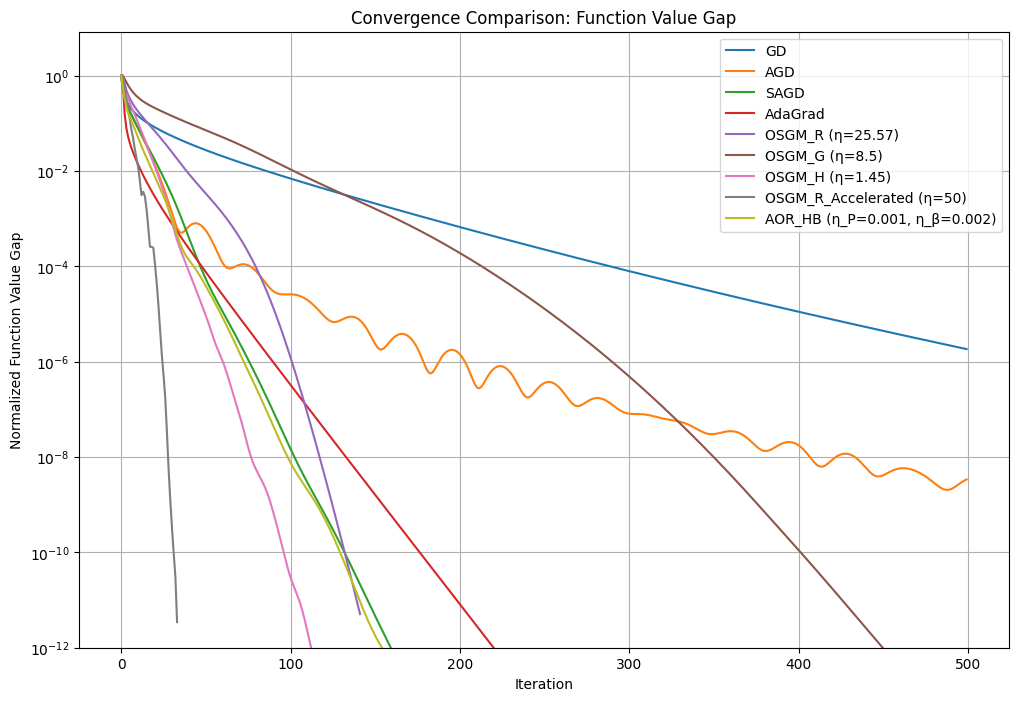

In [19]:
histories_with_info = [
    (gap_history_gd, 'GD', None),
    (gap_history_agd, 'AGD', None),
    (gap_history_sagd, 'SAGD', None),
    (gap_history_adagrad, 'AdaGrad', None),
]

for idx, eta in enumerate(eta_candidates_osgm_r):
    if idx < len(gap_history_osgm_r_all):
        histories_with_info.append((gap_history_osgm_r_all[idx], 'OSGM_R', eta))

for idx, eta in enumerate(eta_candidates_osgm_g):
    if idx < len(gap_history_osgm_g_all):
        histories_with_info.append((gap_history_osgm_g_all[idx], 'OSGM_G', eta))

for idx, eta in enumerate(eta_candidates_osgm_h):
    if idx < len(gap_history_osgm_h_all):
        histories_with_info.append((gap_history_osgm_h_all[idx], 'OSGM_H', eta))

for idx, eta in enumerate(eta_candidates_osgm_r_accelerated):
    if idx < len(gap_history_osgm_r_all_accelerated):
        histories_with_info.append((gap_history_osgm_r_all_accelerated[idx], 'OSGM_R_Accelerated', eta))

for gap_history, eta_P, eta_beta in gap_history_AOR_HB:
    histories_with_info.append((gap_history, f'AOR_HB (η_P={eta_P}, η_β={eta_beta})', None))

plot_convergence_smart(histories_with_info, max_display_iter=500, tol=1e-10, min_display_value=1e-12)

OSGM-R converged at iteration 4033 with gradient norm 3.23e-07 and function gap 9.98e-11
OSGM-H converged at iteration 538 with gradient norm 9.83e-11
OSGM_R_Accelerated converged at iteration 3303 with grad_norm=1.74e-06 and f_gap=2.36e-11
AOR_HB converged at iteration 2213


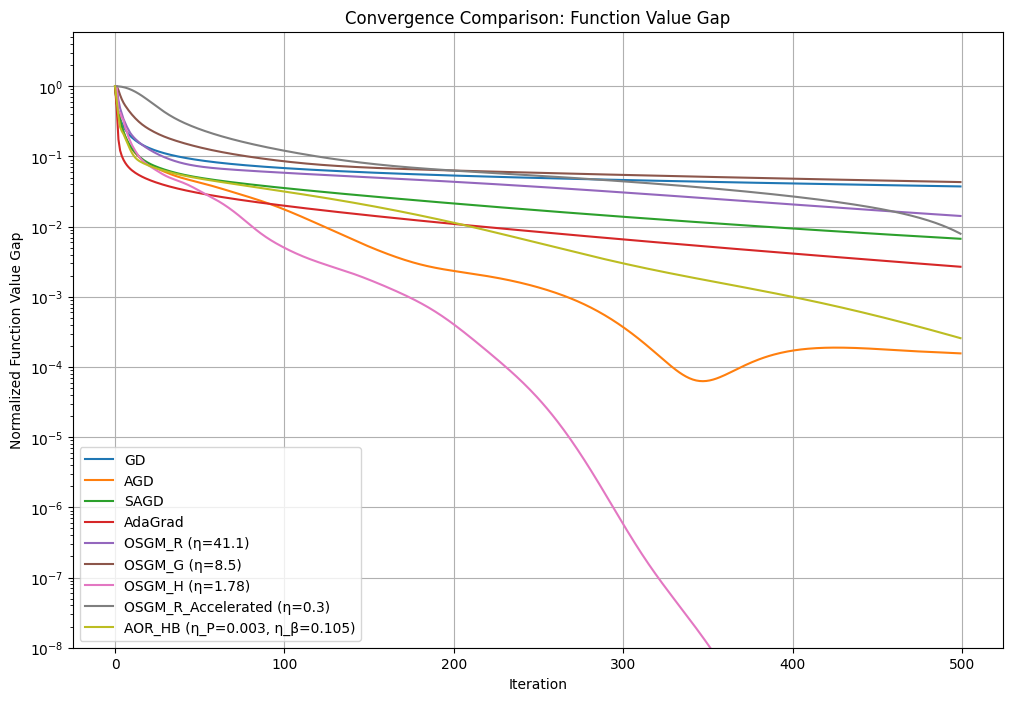

GD converged at iteration 2593 with gradient norm 9.99e-11
AGD converged at iteration 2717 with gradient norm 7.82e-11
SAGD converged at iteration 261 with gradient norm 9.58e-11
AdaGrad converged at iteration 389
OSGM-R converged at iteration 141 with gradient norm 2.05e-06 and function gap 7.98e-11
OSGM-G converged at iteration 636 with gradient norm 9.65e-11
OSGM-H converged at iteration 167 with gradient norm 9.40e-11
OSGM_R_Accelerated converged at iteration 33 with grad_norm=1.61e-05 and f_gap=5.41e-11
AOR_HB converged at iteration 258


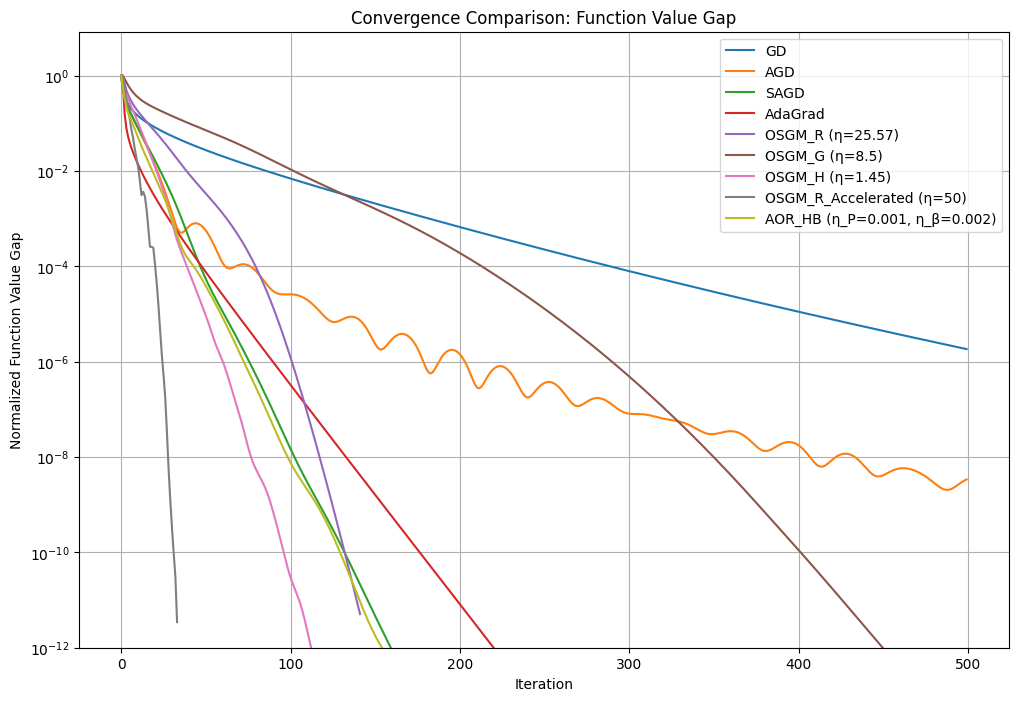

GD converged at iteration 727 with gradient norm 9.83e-11
AGD converged at iteration 929 with gradient norm 8.46e-11
SAGD converged at iteration 211 with gradient norm 9.43e-11
AdaGrad converged at iteration 189
OSGM-R converged at iteration 63 with gradient norm 3.15e-06 and function gap 5.26e-11
OSGM-H converged at iteration 110 with gradient norm 9.79e-11
OSGM_R_Accelerated converged at iteration 23 with grad_norm=2.72e-05 and f_gap=8.94e-11
AOR_HB converged at iteration 127


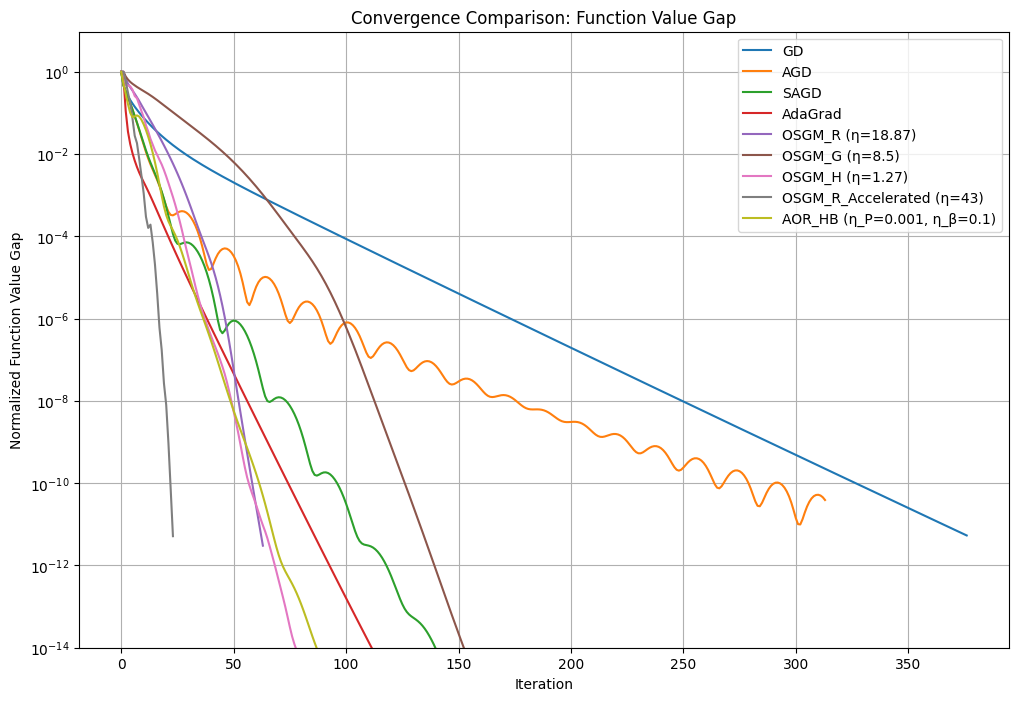

In [20]:
min_display_value_candidates = [1e-8, 1e-12, 1e-14]
eta_candidates_osgm_r_list = [[41.1], [25.57], [18.87]] # also parameters one can change to check different etas, I've chosen the best ones
eta_candidates_osgm_g_list = [[8.5], [8.5], [8.5]]
eta_candidates_osgm_h_list = [[1.78], [1.45], [1.27]]
eta_candidates_osgm_r_accelerated_list = [[0.3], [50], [43]]
eta_P_candidates_AOR_HB_list = [[0.003], [0.001], [0.001]]
eta_beta_candidates_AOR_HB_list = [[0.105], [0.002], [0.1]]
histories_with_info = []
for i in range(0, 3):
  A, b, sigma = datasets[i]
  min_display_value = min_display_value_candidates[i]
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  eta_candidates_osgm_r = eta_candidates_osgm_r_list[i]
  eta_candidates_osgm_g = eta_candidates_osgm_g_list[i]
  eta_candidates_osgm_h = eta_candidates_osgm_h_list[i]
  eta_candidates_osgm_r_accelerated = eta_candidates_osgm_r_accelerated_list[i]
  eta_P_candidates_AOR_HB = eta_P_candidates_AOR_HB_list[i]
  eta_beta_candidates_AOR_HB = eta_beta_candidates_AOR_HB_list[i]

  gap_history_gd = run_basic_optimizer(gd, f, grad_f, x_init, K, f_star, L=L)
  gap_history_agd = run_basic_optimizer(agd, f, grad_f, x_init, K, f_star, L=L)
  gap_history_sagd = run_basic_optimizer(sagd, f, grad_f, x_init, K, f_star, L=L, mu=mu)
  gap_history_adagrad = run_basic_optimizer(adagrad, f, grad_f, x_init, K, f_star)

  gap_history_osgm_r_all = run_osgm_methods(eta_candidates_osgm_r, f, grad_f, P_i, x_init, K, f_star, 'osgm_r')
  gap_history_osgm_g_all = run_osgm_methods(eta_candidates_osgm_g, f, grad_f, P_i, x_init, K, f_star, 'osgm_g', A=A)
  gap_history_osgm_h_all = run_osgm_methods(eta_candidates_osgm_h, f, grad_f, P_i, x_init, K, f_star, 'osgm_h')
  gap_history_osgm_r_all_accelerated = run_osgm_methods(eta_candidates_osgm_r_accelerated, f, grad_f, P_i, x_init, K, f_star,'osgm_r_accelerated', A, b)

  gap_history_AOR_HB = run_AOR_HB_methods(eta_P_candidates_AOR_HB, eta_beta_candidates_AOR_HB,f, grad_f, x_init, K, L, mu, f_star)

  histories_with_info = [
      (gap_history_gd, 'GD', None),
      (gap_history_agd, 'AGD', None),
      (gap_history_sagd, 'SAGD', None),
      (gap_history_adagrad, 'AdaGrad', None),
  ]

  for idx, eta in enumerate(eta_candidates_osgm_r):
      if idx < len(gap_history_osgm_r_all):
          histories_with_info.append((gap_history_osgm_r_all[idx], 'OSGM_R', eta))

  for idx, eta in enumerate(eta_candidates_osgm_g):
      if idx < len(gap_history_osgm_g_all):
          histories_with_info.append((gap_history_osgm_g_all[idx], 'OSGM_G', eta))

  for idx, eta in enumerate(eta_candidates_osgm_h):
      if idx < len(gap_history_osgm_h_all):
          histories_with_info.append((gap_history_osgm_h_all[idx], 'OSGM_H', eta))

  for idx, eta in enumerate(eta_candidates_osgm_r_accelerated):
      if idx < len(gap_history_osgm_r_all_accelerated):
          histories_with_info.append((gap_history_osgm_r_all_accelerated[idx], 'OSGM_R_Accelerated', eta))

  for gap_history, eta_P, eta_beta in gap_history_AOR_HB:
      histories_with_info.append((gap_history, f'AOR_HB (η_P={eta_P}, η_β={eta_beta})', None))

  plot_convergence_smart(histories_with_info, max_display_iter=500, tol=1e-10, min_display_value=min_display_value)

In [52]:
def plot_eta_convergence_analysis(method_name, eta_range, f, grad_f, x_init, num_iterations, f_star,
                                 P_init=None, A=None, b=None, convergence_iter_point=100):
    print(f"Testing {method_name} with {len(eta_range)} eta values")
    print(f"Eta range: from {eta_range[0]:.6f} to {eta_range[-1]:.6f}")

    gap_histories = run_osgm_methods(eta_range, f, grad_f, P_init, x_init, num_iterations, f_star, method_name, A, b)

    plt.figure(figsize=(12, 6))

    convergence_values = []
    valid_eta = []

    for i, eta in enumerate(eta_range):
        if i < len(gap_histories) and gap_histories[i]:
            history = gap_histories[i]
            iter_to_use = min(convergence_iter_point, len(history) - 1)
            convergence_value = history[iter_to_use]
            convergence_values.append(convergence_value)
            valid_eta.append(eta)

            plt.semilogy(eta, convergence_value, 'bo', markersize=8)
            exponent = int(np.log2(eta)) if eta > 0 else -float('inf')
            plt.text(eta, convergence_value * 1.5, f'2^{exponent}', fontsize=8, ha='center')

    plt.xlabel('eta value')
    plt.ylabel(f'Function gap after {convergence_iter_point} iterations')
    plt.title(f'{method_name} Convergence vs eta')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.show()

    plt.figure(figsize=(12, 8))

    for i, eta in enumerate(eta_range):
        if i < len(gap_histories) and gap_histories[i]:
            history = gap_histories[i]
            exponent = int(np.log2(eta)) if eta > 0 else -float('inf')
            plt.plot(history, label=f'η = {eta:.4f} (2^{exponent})', alpha=0.7, linewidth=1)

    plt.xlabel('Iteration')
    plt.ylabel('Normalized Function Value Gap')
    plt.title(f'{method_name} Convergence Trajectories for All eta Values')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    return gap_histories

Sigma: 0.01
Testing osgm_r with 14 eta values
Eta range: from 0.003906 to 32.000000
OSGM-R converged at iteration 9108 with gradient norm 3.10e-07 and function gap 9.95e-11
OSGM-R converged at iteration 6443 with gradient norm 3.10e-07 and function gap 9.95e-11
OSGM-R converged at iteration 4563 with gradient norm 3.15e-07 and function gap 9.95e-11


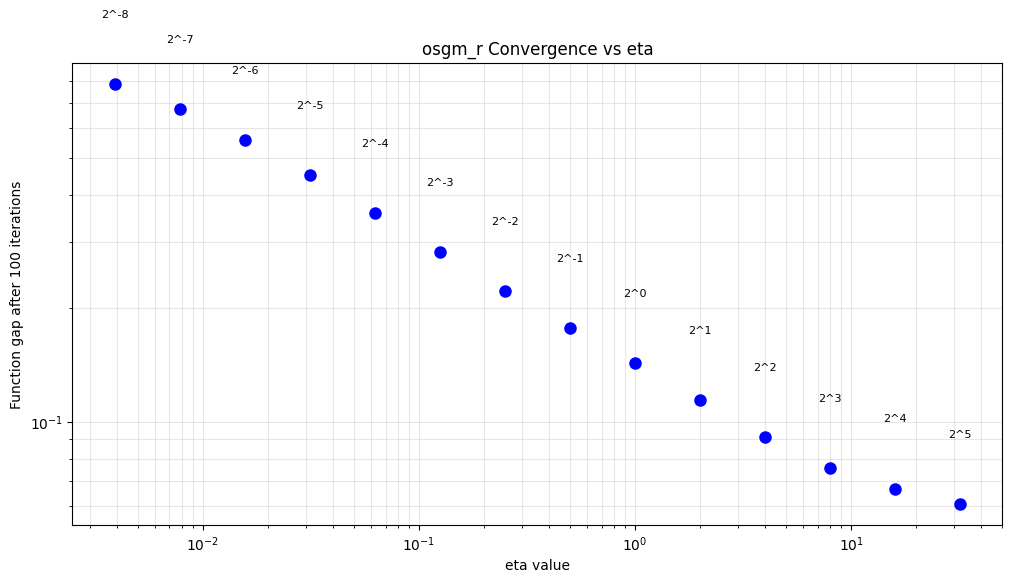

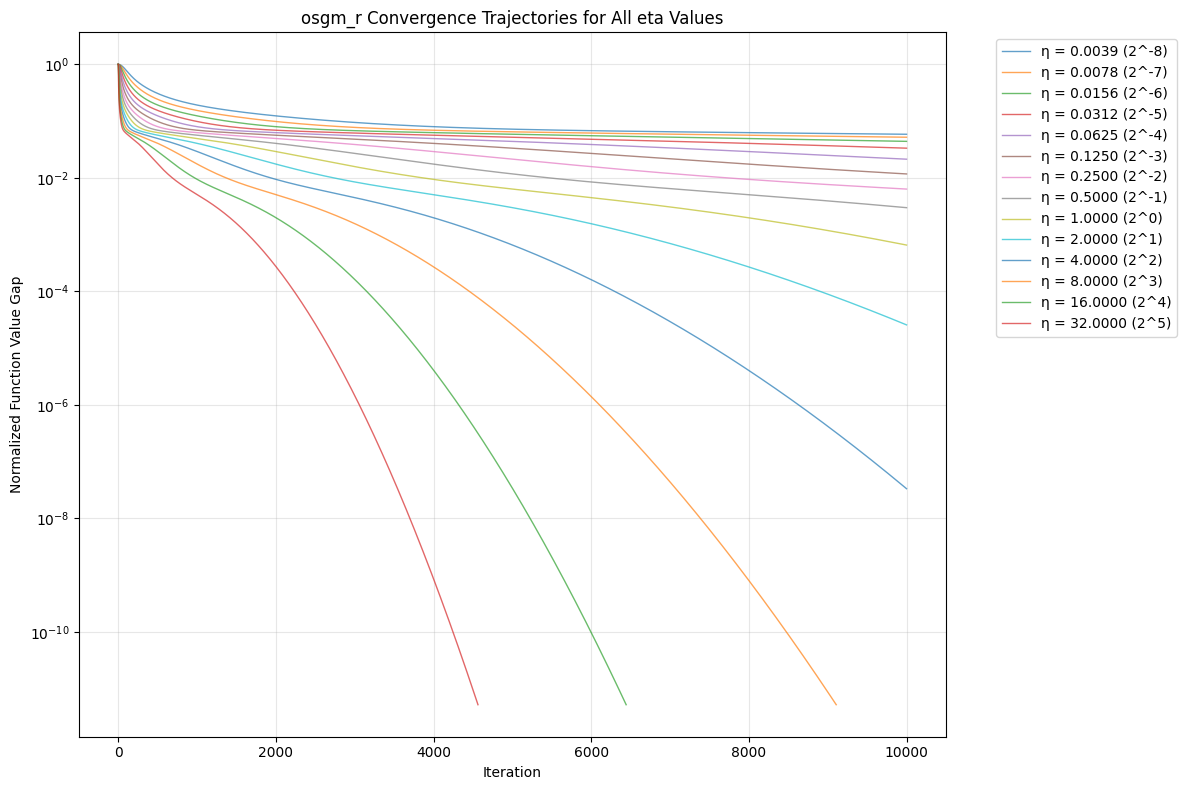

Sigma: 0.1
Testing osgm_r with 13 eta values
Eta range: from 0.003906 to 16.000000
OSGM-R converged at iteration 7911 with gradient norm 2.29e-06 and function gap 9.97e-11
OSGM-R converged at iteration 5595 with gradient norm 2.28e-06 and function gap 9.92e-11
OSGM-R converged at iteration 3957 with gradient norm 2.28e-06 and function gap 9.90e-11
OSGM-R converged at iteration 2798 with gradient norm 2.29e-06 and function gap 9.98e-11
OSGM-R converged at iteration 1979 with gradient norm 2.29e-06 and function gap 9.98e-11
OSGM-R converged at iteration 1400 with gradient norm 2.28e-06 and function gap 9.94e-11
OSGM-R converged at iteration 991 with gradient norm 2.25e-06 and function gap 9.69e-11
OSGM-R converged at iteration 701 with gradient norm 2.27e-06 and function gap 9.86e-11
OSGM-R converged at iteration 497 with gradient norm 2.19e-06 and function gap 9.14e-11
OSGM-R converged at iteration 352 with gradient norm 2.18e-06 and function gap 9.08e-11
OSGM-R converged at iteration 2

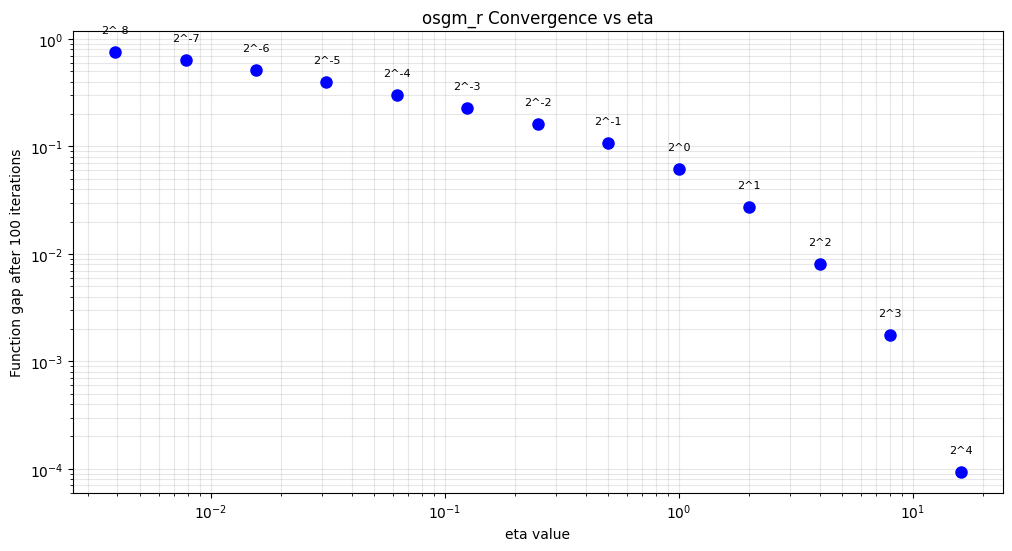

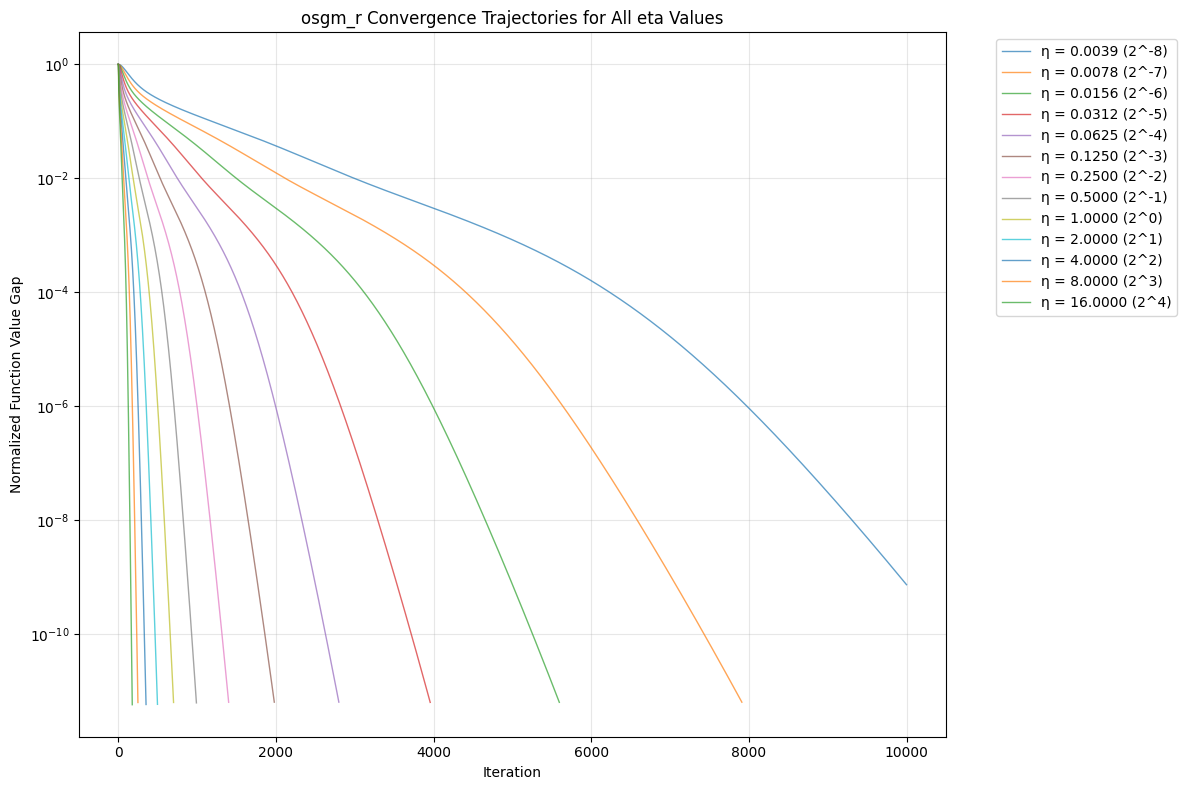

Sigma: 0.2
Testing osgm_r with 13 eta values
Eta range: from 0.003906 to 16.000000
OSGM-R converged at iteration 4213 with gradient norm 4.34e-06 and function gap 9.93e-11
OSGM-R converged at iteration 2979 with gradient norm 4.36e-06 and function gap 1.00e-10
OSGM-R converged at iteration 2107 with gradient norm 4.35e-06 and function gap 9.97e-11
OSGM-R converged at iteration 1491 with gradient norm 4.30e-06 and function gap 9.76e-11
OSGM-R converged at iteration 1055 with gradient norm 4.27e-06 and function gap 9.63e-11
OSGM-R converged at iteration 746 with gradient norm 4.32e-06 and function gap 9.86e-11
OSGM-R converged at iteration 528 with gradient norm 4.30e-06 and function gap 9.77e-11
OSGM-R converged at iteration 374 with gradient norm 4.24e-06 and function gap 9.48e-11
OSGM-R converged at iteration 265 with gradient norm 4.18e-06 and function gap 9.24e-11
OSGM-R converged at iteration 188 with gradient norm 4.06e-06 and function gap 8.74e-11
OSGM-R converged at iteration 13

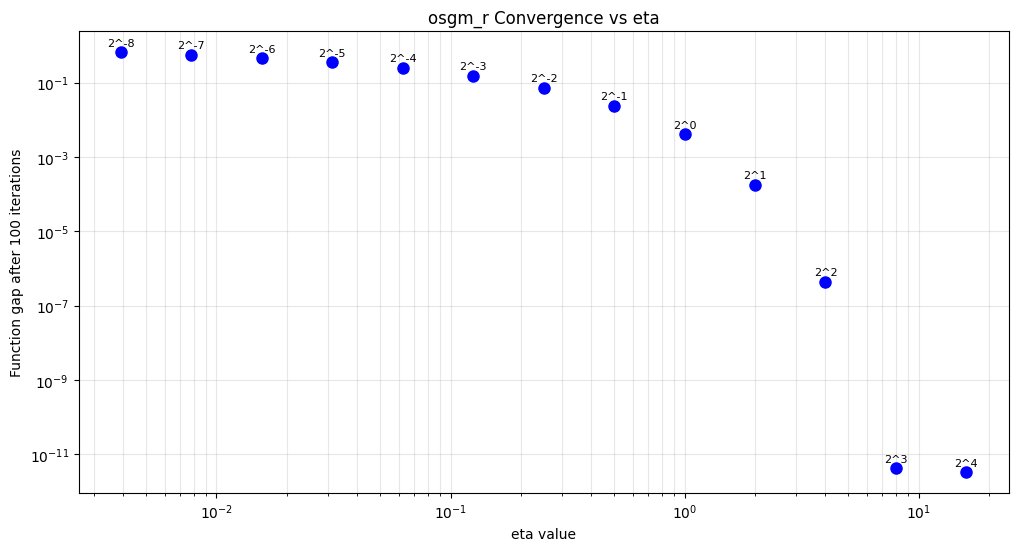

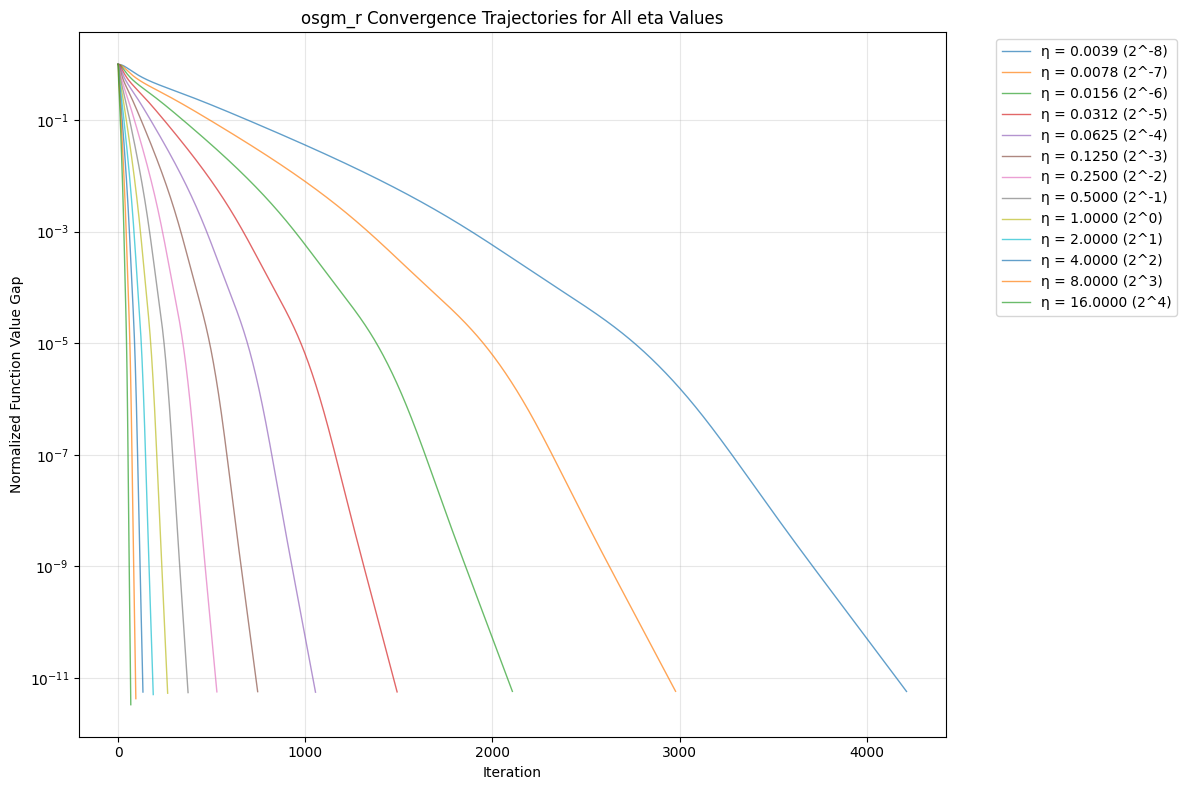

In [53]:
eta_range_osgm_r = [[2.0 ** exp for exp in range(-8, 6)], [2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 5)]]
for i in range(0, 3):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_r= plot_eta_convergence_analysis(
      'osgm_r', eta_range_osgm_r[i], f, grad_f, x_init, K, f_star, P_i
  )


Sigma: 0.01
Testing osgm_g with 13 eta values
Eta range: from 0.003906 to 16.000000


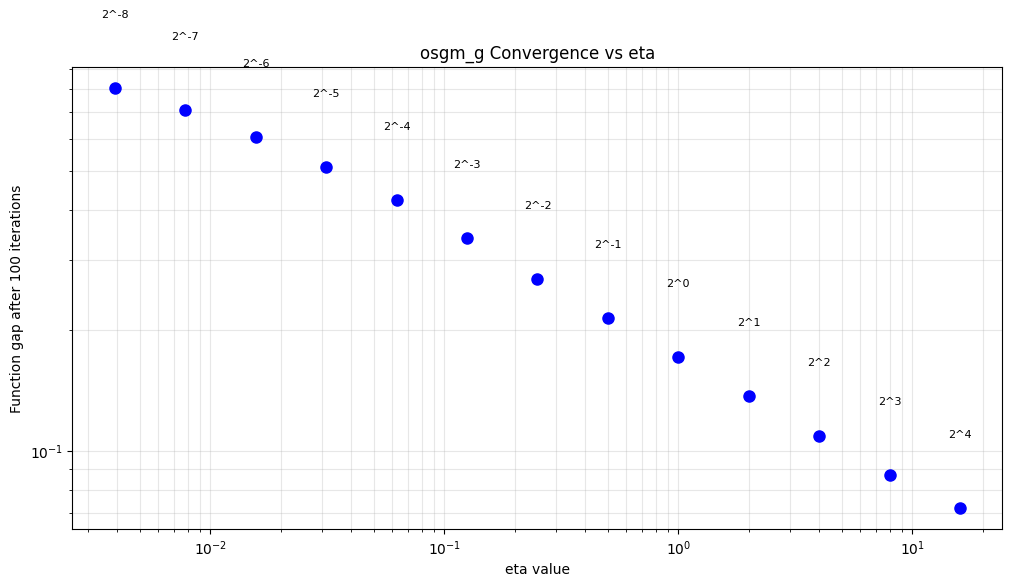

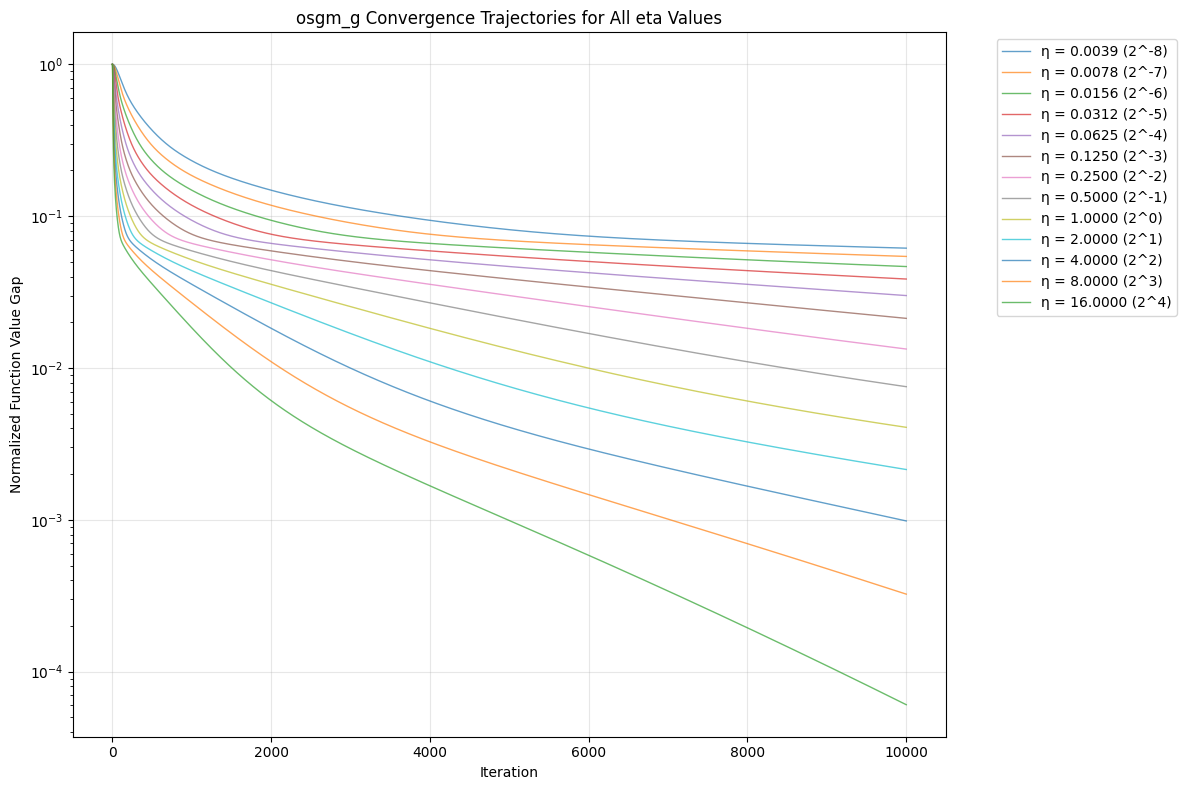

Sigma: 0.1
Testing osgm_g with 12 eta values
Eta range: from 0.003906 to 8.000000
OSGM-G converged at iteration 7342 with gradient norm 9.96e-11
OSGM-G converged at iteration 5189 with gradient norm 9.99e-11
OSGM-G converged at iteration 3668 with gradient norm 9.93e-11
OSGM-G converged at iteration 2591 with gradient norm 9.99e-11
OSGM-G converged at iteration 1831 with gradient norm 9.86e-11
OSGM-G converged at iteration 1293 with gradient norm 9.80e-11
OSGM-G converged at iteration 686 with gradient norm 9.71e-11


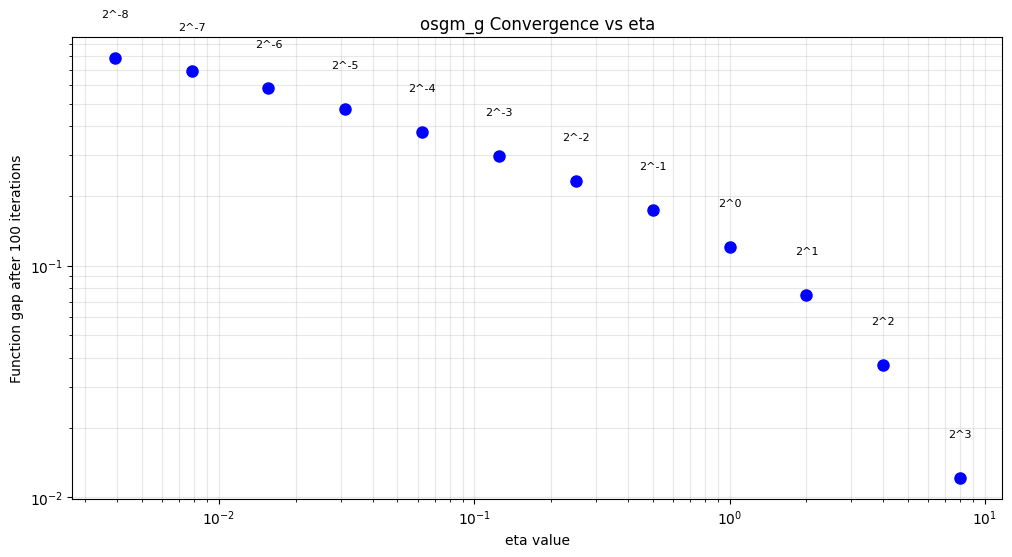

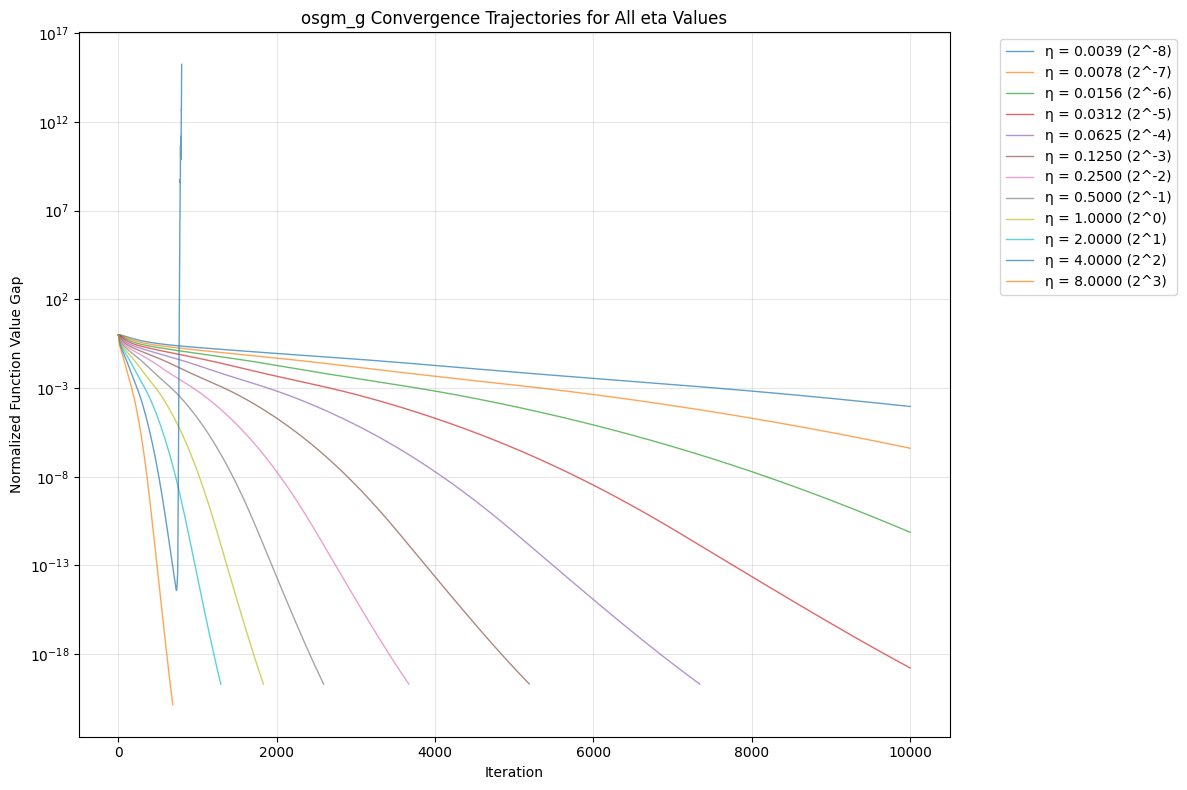

Sigma: 0.2
Testing osgm_g with 11 eta values
Eta range: from 0.003906 to 4.000000
OSGM-G converged at iteration 9746 with gradient norm 9.99e-11
OSGM-G converged at iteration 6890 with gradient norm 9.98e-11
OSGM-G converged at iteration 4871 with gradient norm 9.95e-11
OSGM-G converged at iteration 3442 with gradient norm 1.00e-10
OSGM-G converged at iteration 2433 with gradient norm 9.92e-11
OSGM-G converged at iteration 1719 with gradient norm 9.88e-11
OSGM-G converged at iteration 1214 with gradient norm 9.86e-11
OSGM-G converged at iteration 857 with gradient norm 9.81e-11
OSGM-G converged at iteration 604 with gradient norm 9.99e-11
OSGM-G converged at iteration 426 with gradient norm 9.72e-11
OSGM-G converged at iteration 300 with gradient norm 9.27e-11


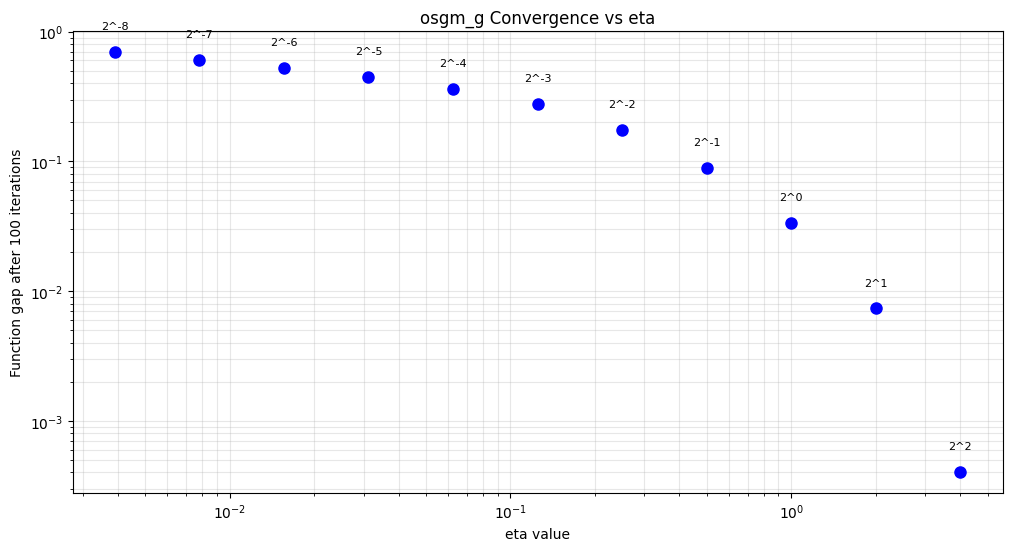

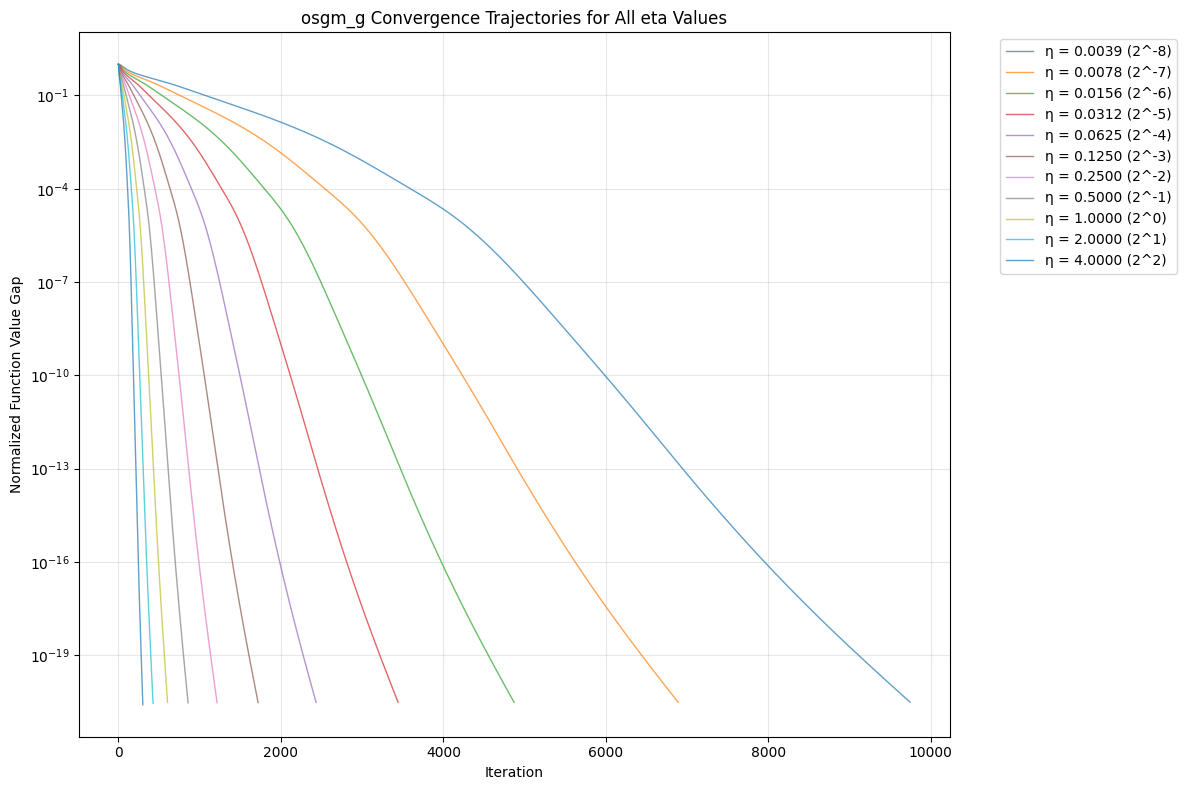

In [55]:
eta_range_osgm_g = [[2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 4)], [2.0 ** exp for exp in range(-8, 3)]]
for i in range(0, 3):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_g= plot_eta_convergence_analysis(
      'osgm_g', eta_range_osgm_g[i], f, grad_f, x_init, K, f_star, P_i, A=A
  )


Sigma: 0.01
Testing osgm_h with 9 eta values
Eta range: from 0.003906 to 1.000000
OSGM-H converged at iteration 7957 with gradient norm 9.99e-11
OSGM-H converged at iteration 5628 with gradient norm 9.97e-11
OSGM-H converged at iteration 3981 with gradient norm 9.95e-11
OSGM-H converged at iteration 2816 with gradient norm 9.98e-11
OSGM-H converged at iteration 1993 with gradient norm 9.89e-11
OSGM-H converged at iteration 1411 with gradient norm 9.79e-11
OSGM-H converged at iteration 999 with gradient norm 9.88e-11
OSGM-H converged at iteration 709 with gradient norm 9.60e-11


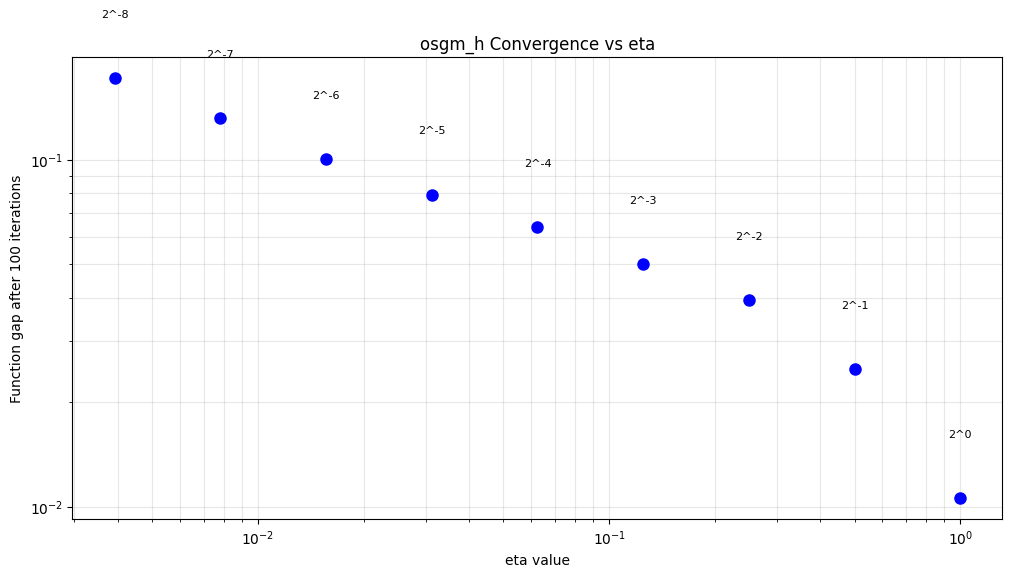

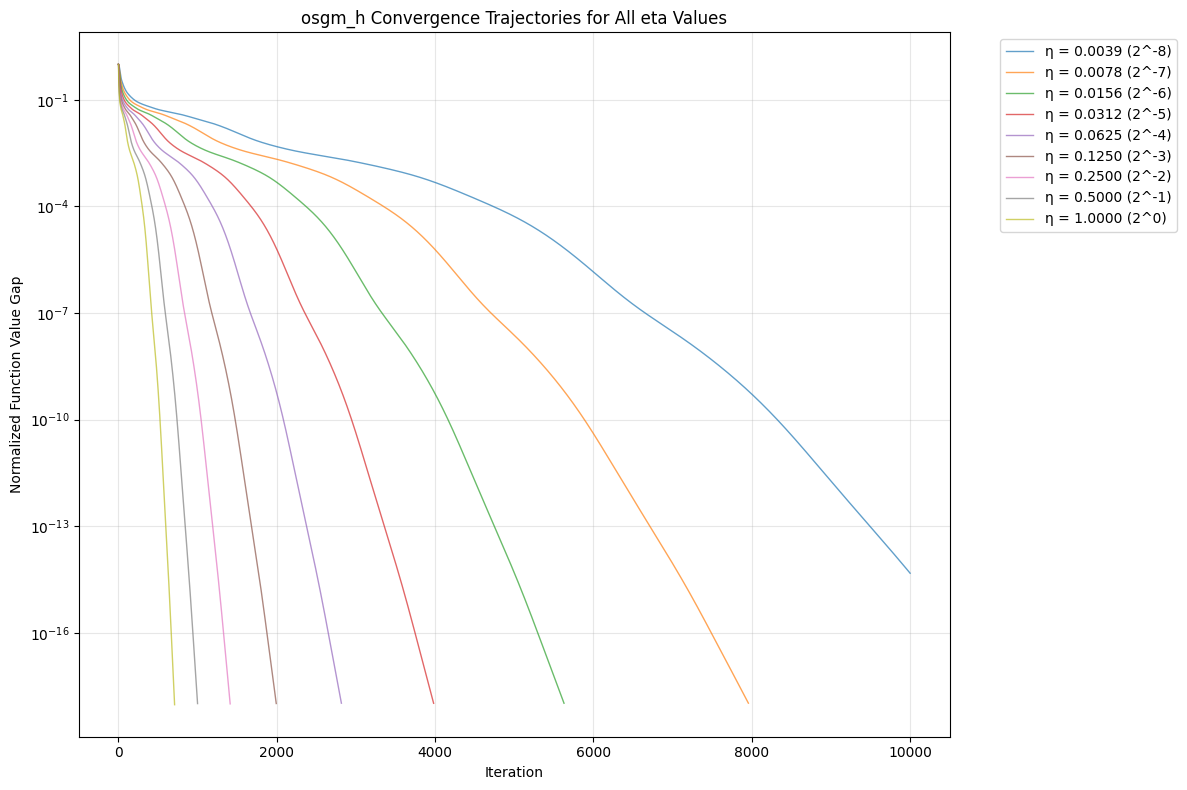

Sigma: 0.1
Testing osgm_h with 9 eta values
Eta range: from 0.003906 to 1.000000
OSGM-H converged at iteration 2747 with gradient norm 9.93e-11
OSGM-H converged at iteration 1945 with gradient norm 9.93e-11
OSGM-H converged at iteration 1378 with gradient norm 9.91e-11
OSGM-H converged at iteration 977 with gradient norm 9.89e-11
OSGM-H converged at iteration 694 with gradient norm 9.63e-11
OSGM-H converged at iteration 493 with gradient norm 9.84e-11
OSGM-H converged at iteration 352 with gradient norm 9.29e-11
OSGM-H converged at iteration 252 with gradient norm 9.20e-11
OSGM-H converged at iteration 182 with gradient norm 9.03e-11


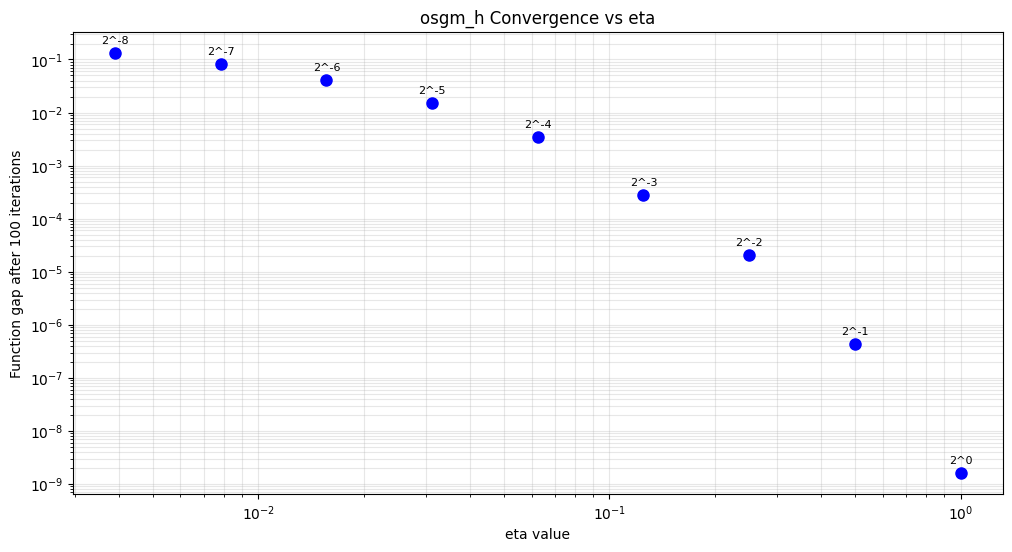

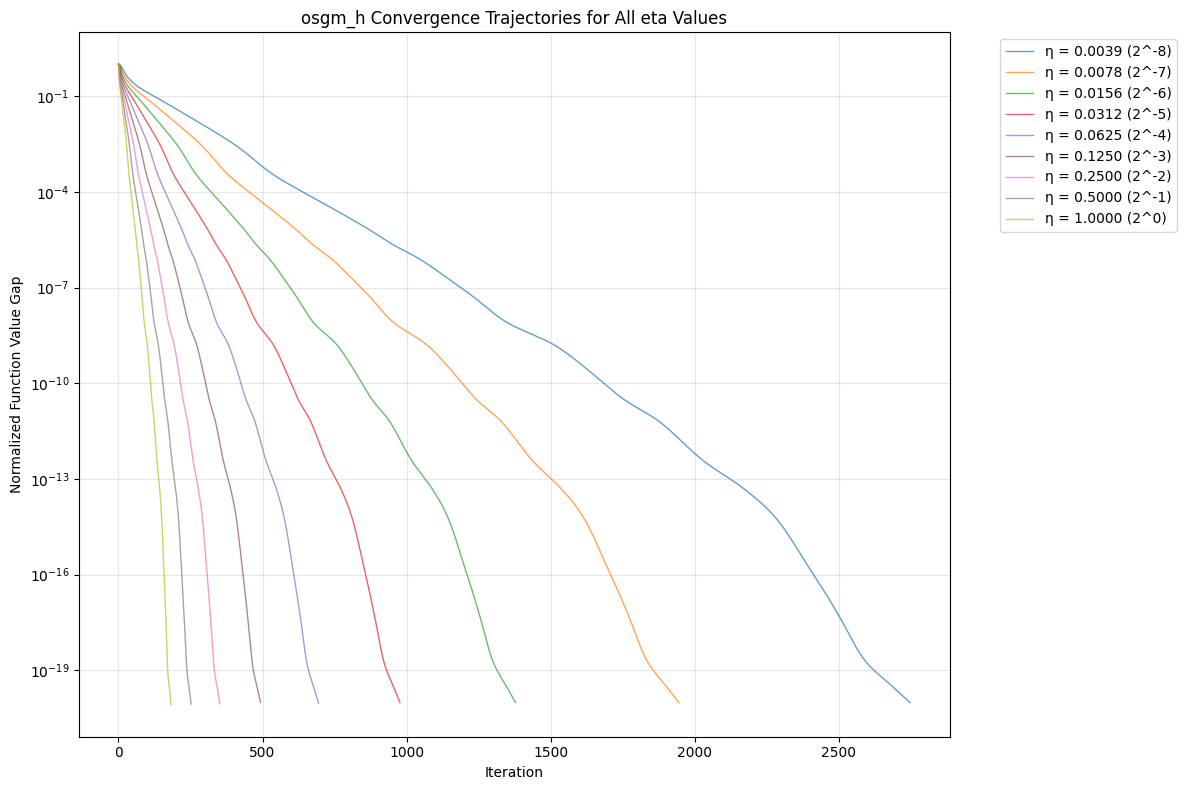

Sigma: 0.2
Testing osgm_h with 9 eta values
Eta range: from 0.003906 to 1.000000
OSGM-H converged at iteration 1704 with gradient norm 9.87e-11
OSGM-H converged at iteration 1208 with gradient norm 9.75e-11
OSGM-H converged at iteration 857 with gradient norm 9.68e-11
OSGM-H converged at iteration 609 with gradient norm 9.49e-11
OSGM-H converged at iteration 433 with gradient norm 9.70e-11
OSGM-H converged at iteration 309 with gradient norm 9.53e-11
OSGM-H converged at iteration 221 with gradient norm 9.87e-11
OSGM-H converged at iteration 160 with gradient norm 8.53e-11
OSGM-H converged at iteration 118 with gradient norm 8.79e-11


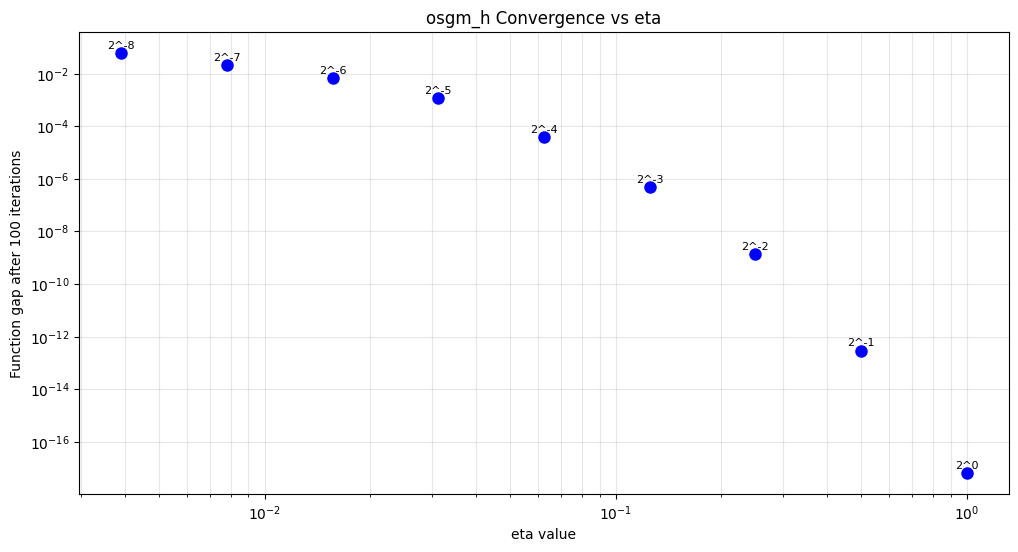

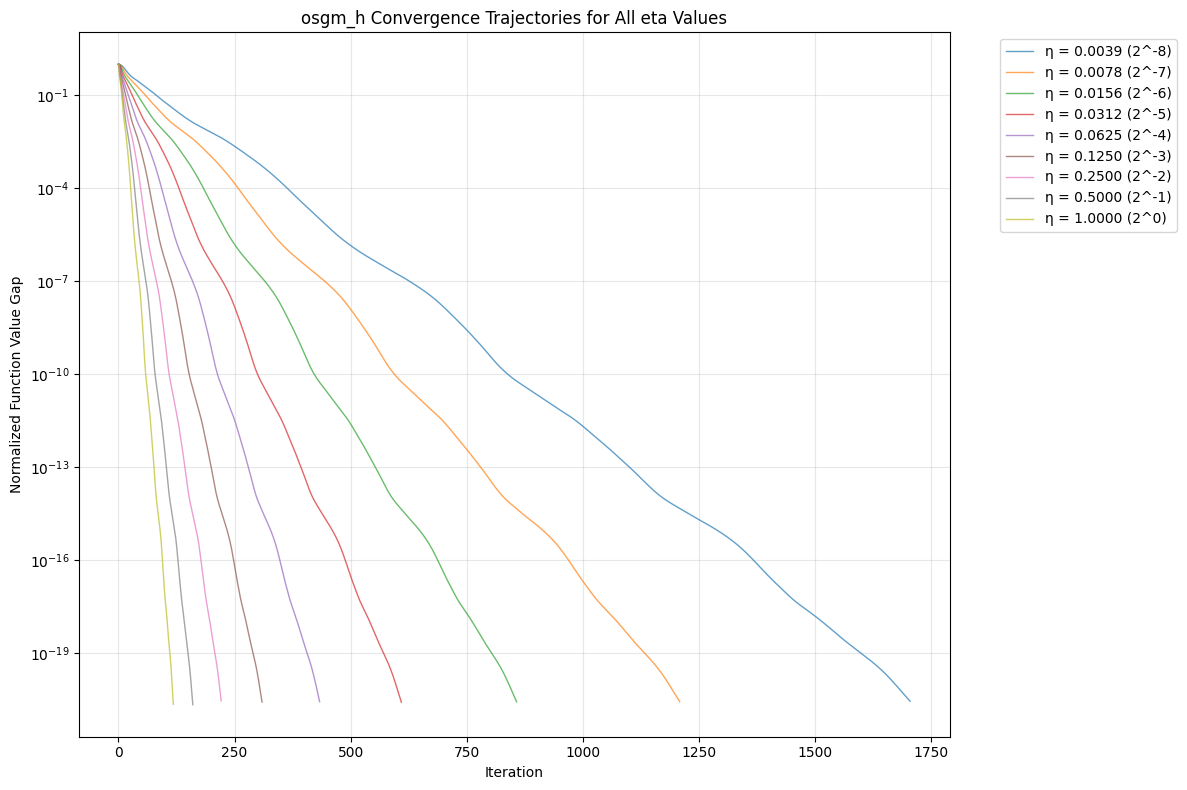

In [59]:
eta_range_osgm_h = [[2.0 ** exp for exp in range(-8, 1)], [2.0 ** exp for exp in range(-8, 1)], [2.0 ** exp for exp in range(-8, 1)]]
for i in range(0, 3):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_h = plot_eta_convergence_analysis(
      'osgm_h', eta_range_osgm_h[i], f, grad_f, x_init, K, f_star, P_i
  )

Sigma: 0.01
Testing osgm_r_accelerated with 13 eta values
Eta range: from 0.003906 to 16.000000
OSGM_R_Accelerated converged at iteration 5358 with grad_norm=2.76e-07 and f_gap=9.38e-11
OSGM_R_Accelerated converged at iteration 4308 with grad_norm=8.76e-07 and f_gap=9.87e-11
OSGM_R_Accelerated converged at iteration 2048 with grad_norm=2.17e-06 and f_gap=6.46e-11
OSGM_R_Accelerated converged at iteration 6074 with grad_norm=2.56e-06 and f_gap=3.14e-11
OSGM_R_Accelerated converged at iteration 4440 with grad_norm=1.58e-06 and f_gap=3.26e-11
OSGM_R_Accelerated converged at iteration 739 with grad_norm=7.92e-06 and f_gap=9.04e-11
OSGM_R_Accelerated converged at iteration 487 with grad_norm=1.34e-05 and f_gap=6.62e-11
OSGM_R_Accelerated converged at iteration 1289 with grad_norm=7.44e-06 and f_gap=6.71e-11


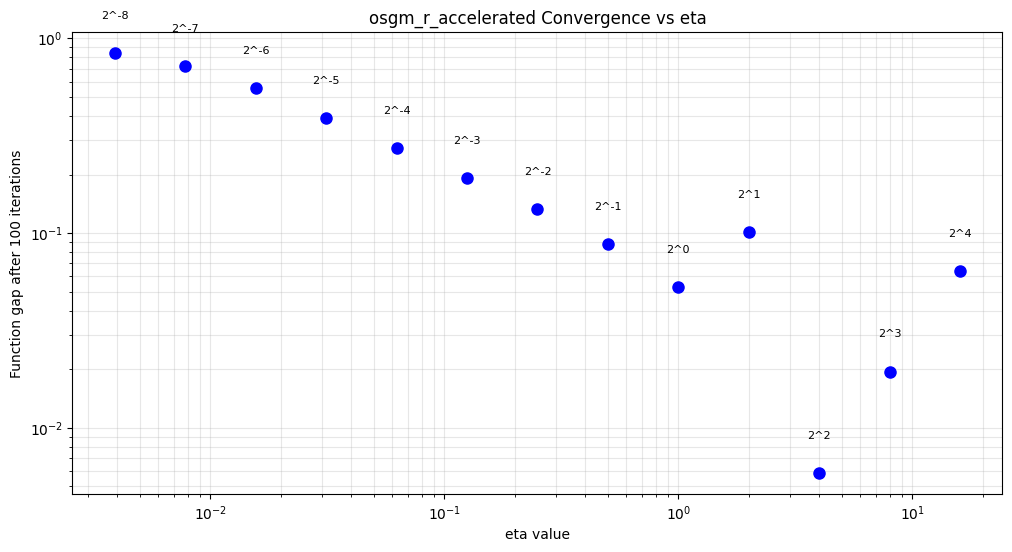

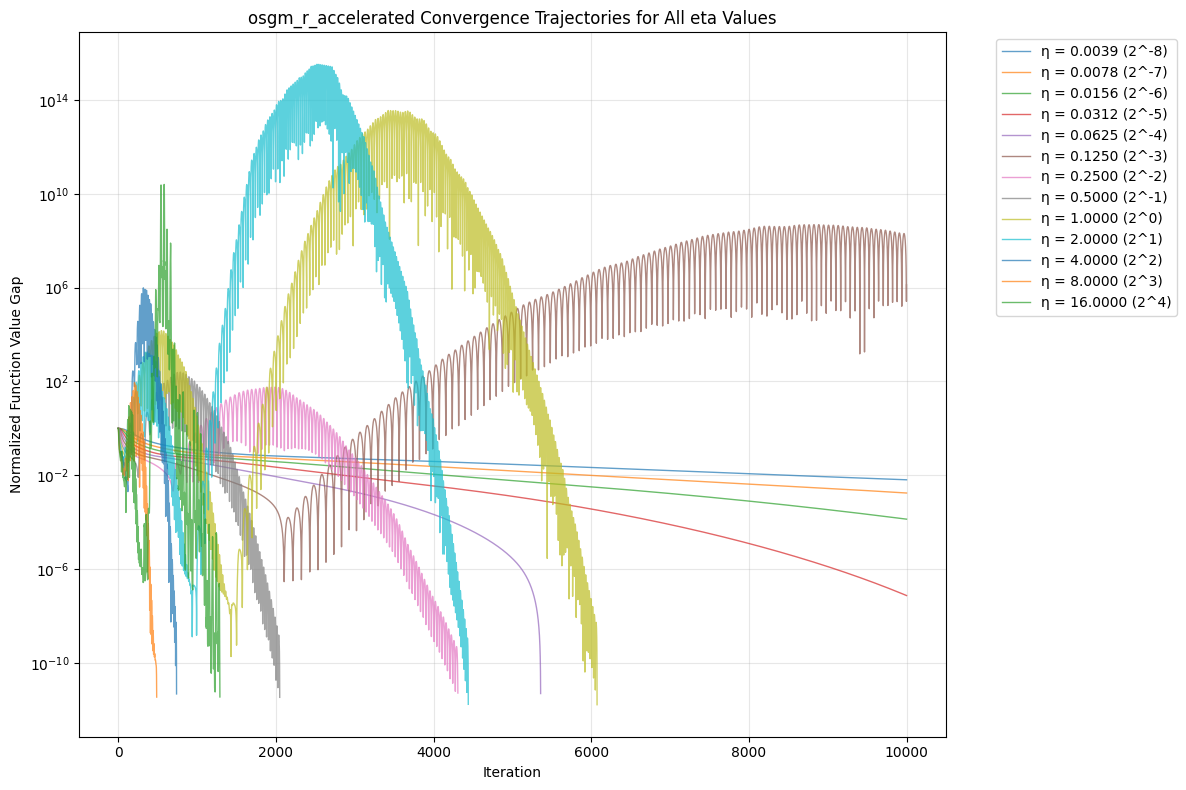

Sigma: 0.1
Testing osgm_r_accelerated with 13 eta values
Eta range: from 0.003906 to 16.000000
OSGM_R_Accelerated converged at iteration 4104 with grad_norm=3.01e-06 and f_gap=9.97e-11
OSGM_R_Accelerated converged at iteration 2834 with grad_norm=3.01e-06 and f_gap=9.93e-11
OSGM_R_Accelerated converged at iteration 1923 with grad_norm=3.01e-06 and f_gap=9.88e-11
OSGM_R_Accelerated converged at iteration 1276 with grad_norm=2.98e-06 and f_gap=9.66e-11
OSGM_R_Accelerated converged at iteration 840 with grad_norm=3.00e-06 and f_gap=9.89e-11
OSGM_R_Accelerated converged at iteration 535 with grad_norm=2.86e-06 and f_gap=9.66e-11
OSGM_R_Accelerated converged at iteration 319 with grad_norm=2.48e-06 and f_gap=6.75e-11
OSGM_R_Accelerated converged at iteration 237 with grad_norm=2.68e-06 and f_gap=7.56e-11
OSGM_R_Accelerated converged at iteration 207 with grad_norm=3.68e-06 and f_gap=8.10e-11
OSGM_R_Accelerated converged at iteration 151 with grad_norm=2.54e-06 and f_gap=7.96e-11
OSGM_R_Acce

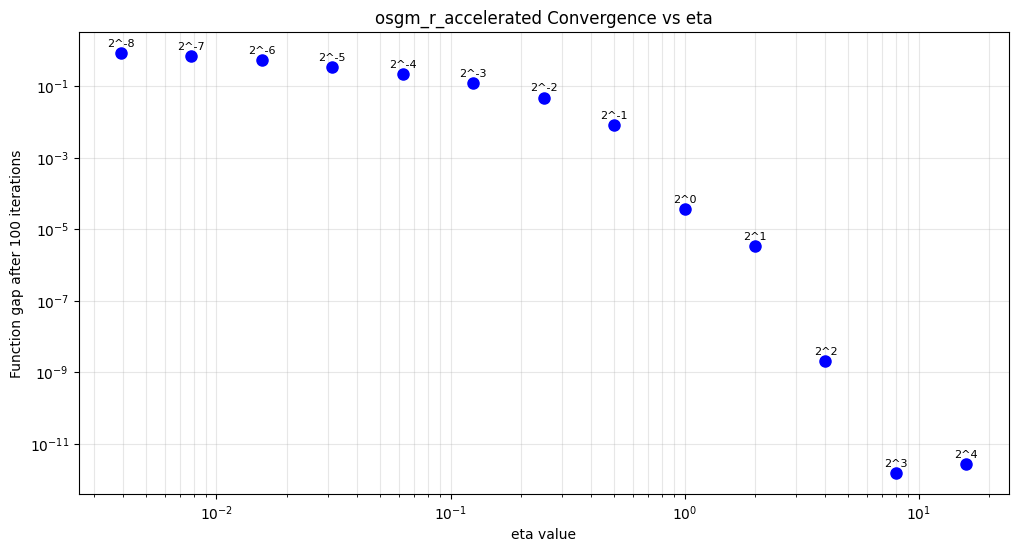

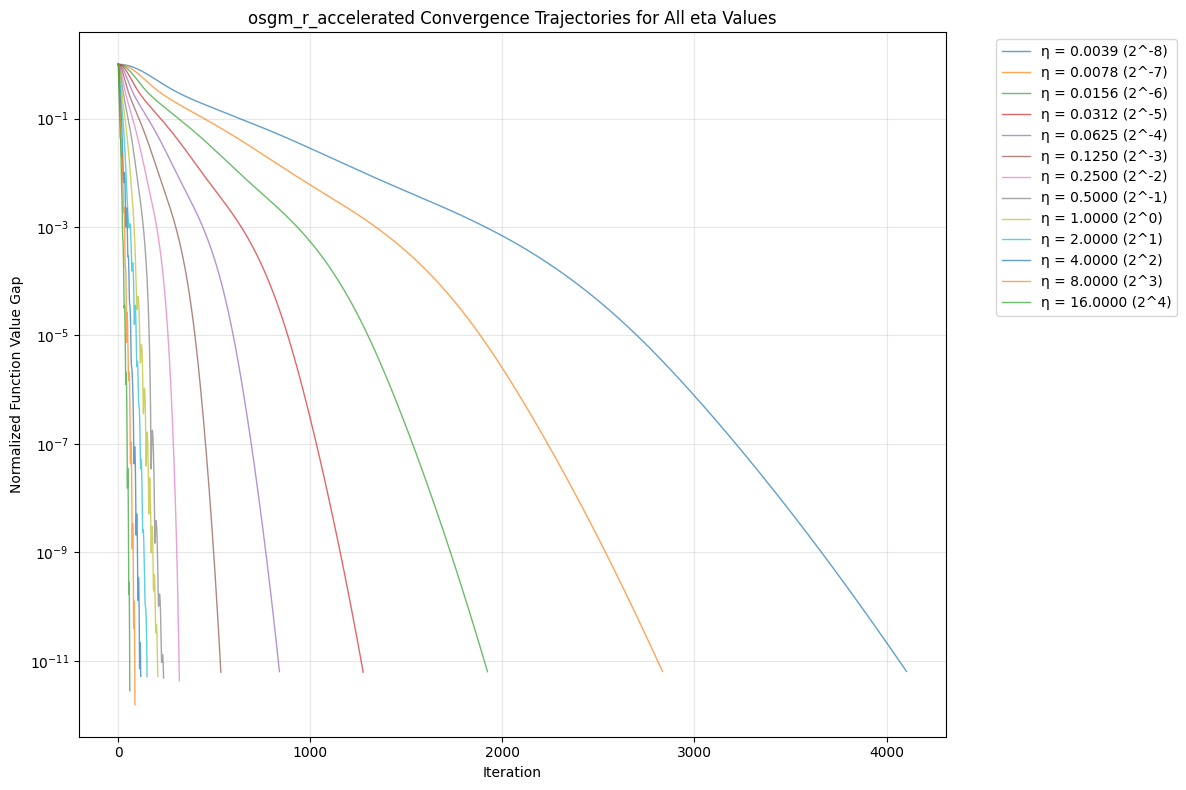

Sigma: 0.2
Testing osgm_r_accelerated with 15 eta values
Eta range: from 0.003906 to 64.000000
OSGM_R_Accelerated converged at iteration 2439 with grad_norm=5.17e-06 and f_gap=9.99e-11
OSGM_R_Accelerated converged at iteration 1698 with grad_norm=5.15e-06 and f_gap=9.97e-11
OSGM_R_Accelerated converged at iteration 1178 with grad_norm=5.04e-06 and f_gap=9.60e-11
OSGM_R_Accelerated converged at iteration 812 with grad_norm=4.96e-06 and f_gap=9.44e-11
OSGM_R_Accelerated converged at iteration 553 with grad_norm=4.94e-06 and f_gap=9.65e-11
OSGM_R_Accelerated converged at iteration 370 with grad_norm=4.85e-06 and f_gap=9.92e-11
OSGM_R_Accelerated converged at iteration 241 with grad_norm=3.88e-06 and f_gap=7.26e-11
OSGM_R_Accelerated converged at iteration 155 with grad_norm=3.55e-06 and f_gap=8.64e-11
OSGM_R_Accelerated converged at iteration 117 with grad_norm=4.49e-06 and f_gap=8.43e-11
OSGM_R_Accelerated converged at iteration 95 with grad_norm=3.66e-06 and f_gap=6.08e-11
OSGM_R_Accele

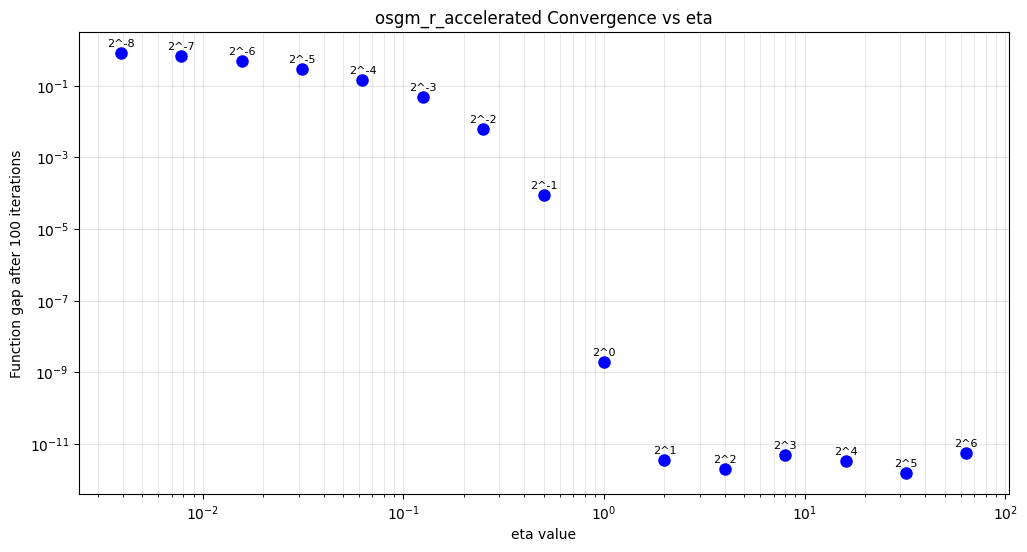

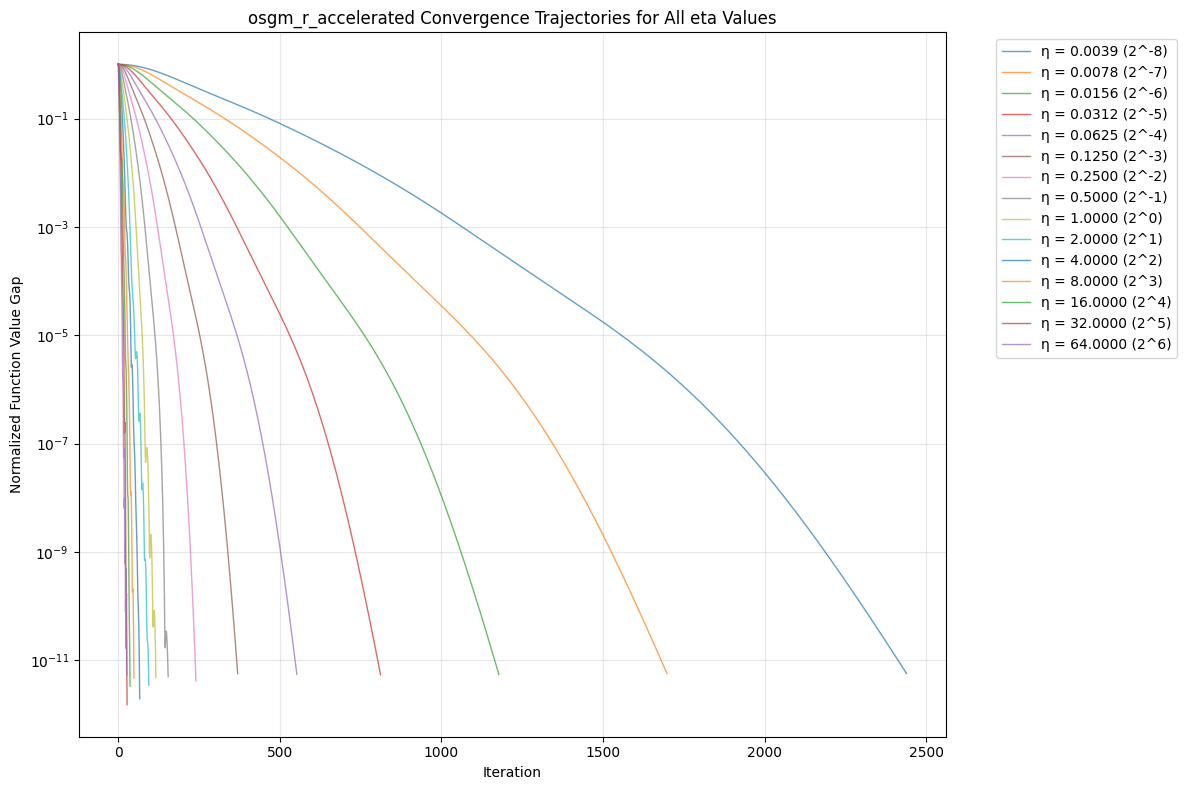

In [63]:
eta_range_osgm_r_acc = [[2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 7)]]
for i in range(0, 3):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_r_acc = plot_eta_convergence_analysis(
      'osgm_r_accelerated', eta_range_osgm_r_acc[i], f, grad_f, x_init, K, f_star, P_i, A, b
  )